In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
import cv2
from PIL import Image

In [3]:
import sys
sys.path.append("C:/git/computer-vision-control/")

# Read images

In [4]:
from glob import glob

In [5]:
hand_files = glob("C:/git/computer-vision-control/images/hand_detection/hand/*.png")
not_hand_files = glob("C:/git/computer-vision-control/images/hand_detection/not_hand/*.png")

In [6]:
len(hand_files)

319

In [7]:
len(not_hand_files)

312

# Camera Image

## Preprocessing

In [8]:
from vision_control.camera import *

In [9]:
img = CameraImage(file_path=hand_files[50])

In [10]:
img.preprocess(canny_intensity=30)

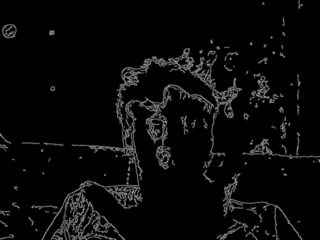

In [11]:
img

## Building the dataset

In [12]:
hand_img = [CameraImage(file_path = file_path,tag = 1,check = True) for file_path in tqdm(hand_files,desc = "Loading hand images")]
not_hand_img = [CameraImage(file_path = file_path,tag = 0,check = True) for file_path in tqdm(not_hand_files,desc = "Loading not hand images")]
all_img = hand_img + not_hand_img
all_img = [img for img in all_img if img.ok]

Loading not hand images: 100%|███████████████| 312/312 [00:04<00:00, 66.68it/s]


In [13]:
images = CameraImages(camera_images=all_img)

In [14]:
images.preprocess()

Preprocessing images: 100%|█████████████████| 629/629 [00:01<00:00, 358.40it/s]


In [15]:
X = images.build_X()

In [16]:
X.shape

(629, 76800)

In [17]:
X = np.divide(X,255)

In [15]:
y = images.build_y()

In [16]:
y.shape

(629, 1)

# Train a simple model

In [17]:
# Keras
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import model_from_json

Using TensorFlow backend.


## Creating the MLP

In [68]:
model = Sequential()
model.add(Dense(256,input_dim = X.shape[1],activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [69]:
model.fit(X,y,validation_split=0.1,epochs=5,verbose = 2)

Train on 566 samples, validate on 63 samples
Epoch 1/5
24s - loss: 0.5357 - acc: 0.8233 - val_loss: 0.8838 - val_acc: 0.7937
Epoch 2/5
10s - loss: 0.1428 - acc: 0.9594 - val_loss: 1.2967 - val_acc: 0.7460
Epoch 3/5
10s - loss: 0.0275 - acc: 0.9876 - val_loss: 0.6780 - val_acc: 0.7778
Epoch 4/5
10s - loss: 0.0152 - acc: 0.9965 - val_loss: 0.4898 - val_acc: 0.8889
Epoch 5/5
10s - loss: 0.0041 - acc: 0.9982 - val_loss: 0.9693 - val_acc: 0.7778


## Live test

##### True negative example

In [70]:
test = CameraImage(capture = True)

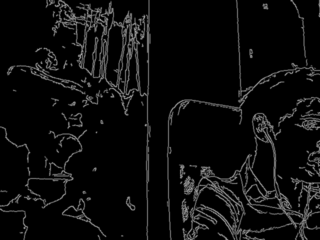

In [71]:
test.preprocess()
test

In [72]:
test.predict(model)

0.00029071741

##### False negative example

In [73]:
test = CameraImage(capture = True)

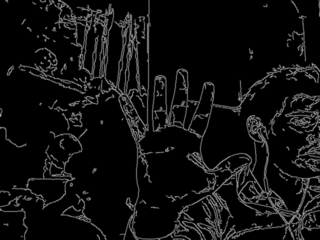

In [74]:
test.preprocess()
test

In [75]:
test.predict(model)

5.3994472e-06

## Conclusion : 
The model fit very well on the train and dev set, but does not generalize to pictures in a production setting

# Train a more complex model : CNN

## Building a dataset not flattened

In [19]:
X = images.build_X(flatten=False)
X.shape

(629, 240, 320, 1)

## Creating the model

In [21]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=(240,320,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.01)
model.compile(optimizer="sgd", loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
model.fit(X,y,validation_split=0.3,epochs=1,verbose = 1)

Train on 566 samples, validate on 63 samples
Epoch 1/1
128/566 [=====>........................] - ETA: 560s - loss: 1.4769 - acc: 0.593 - ETA: 441s - loss: 4.7680 - acc: 0.546 - ETA: 360s - loss: 6.8724 - acc: 0.468 - ETA: 308s - loss: 7.6727 - acc: 0.4453

KeyboardInterrupt: 